# Environment Setting

In [1]:
%cd /Users/edoardorossi/Documents/GitHub/Last_tesi
PROJECT_PATH = '/Users/edoardorossi/Documents/GitHub/Last_tesi'
CTA30_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os


sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold


#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.mapping import sub2ind3d, ind2sub, ind2sub3d
#from functions.policy_functions import policy_evaluation, policy_improvement, policy_iteration, policy_optim, value_iteration
from functions.dynamic_programming import policy_eval, policy_improv, policy_iteration, value_iteration
from functions.matrix_build import build_T, is_ergodic, is_markovian

import random
from collections import defaultdict

import time

import joblib



print("Libraries imported")

/Users/edoardorossi/Documents/GitHub/Last_tesi


Libraries imported


# Data Loading

In [2]:
cta30_def_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)

df = pd.read_csv(os.path.join(PROJECT_PATH, 'df.csv'))
df_a = pd.read_csv(os.path.join(PROJECT_PATH, 'df_a.csv'))
df_rew = pd.read_csv(os.path.join(PROJECT_PATH, 'df_rew.csv'))

df_mdp_norm_path = os.path.join(PROJECT_PATH, 'MDP_clean_data/kmeans/df_mdp_norm_212_a7.csv')
df_mdp_norm = pd.read_csv(df_mdp_norm_path)
#create a variable ppath equal to the last part of the path of df_mdp_norm
ppath = df_mdp_norm_path[df_mdp_norm_path.find('norm')+5:]
ppath = ppath[:-4]

df_mdp = df_mdp_norm.copy()




# Building T

## Cross Validation for T

In [8]:
def build_T(df_mdp):

    SA_col = df_mdp[['S', 'At']]
    
    S = SA_col['S'].max()+1
    A = SA_col['At'].max()+1
    T = np.zeros((S, S, A), dtype=float)
   
    for j in range(df_mdp.shape[0]-1):
        s = df_mdp.iloc[j]['S']
        s_ = df_mdp.iloc[j+1]['S']
        a = df_mdp.iloc[j]['At']
        T[s,s_,a] += 1
    
    # Normalize T to be a stochastic matrix
    T = T.astype('float64')

    none_index = []
    for a in range(A):
        for s in range(S):
            if T[s, :, a].sum() > 0:
                T[s, :, a] /= T[s, :, a].sum()
            if T[s,:,a].sum() == 0:
                none_index.append((s,a))
    #for index in none_index:
    #    T[index[0],index[0],index[1]] = 1

    return T, none_index

In [9]:
n_splits = 10
validation_size = int(df_mdp.shape[0]*(1/n_splits))
#create 10 intervals of size validation_size from df_mdp

intervals = []

for i in range(n_splits):
    intervals.append(df_mdp.iloc[i*validation_size:(i+1)*validation_size,:])
    print(intervals[i].shape)
intervals.append(df_mdp.iloc[n_splits*validation_size:,:])

accuracy = []
for i in range(n_splits):

    df_train = pd.concat(intervals[:i] + intervals[i+1:]).copy()
    df_val = intervals[i].copy().reset_index(drop=True)
    T, _= build_T(df_train)

    kfold_accuracy = 0
    val_size = df_val.shape[0]
    for j in range(val_size-1):
        s = df_val.loc[j,'S']
        a = df_val.loc[j,'At']
        s_ = df_val.loc[j+1,'S']
        if max(s, s_) <= (T.shape[0] - 1) and T[s, s_, a] > 0:
            kfold_accuracy += 1
    accuracy.append(kfold_accuracy/val_size)
    
print('Accuracy of validation set computed with kfold',n_splits,' is ', np.mean(accuracy))


(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
(217637, 2)
Accuracy of validation set computed with kfold 10  is  0.725842572724307


In [5]:
df_mdp.loc[0,'S']

73

## Building T

In [4]:
T, nnidx = build_T2(df_mdp)

In [6]:
print(len(nnidx))
print(T.shape[0]* T.shape[2])


1146
1484
T is markovian: False


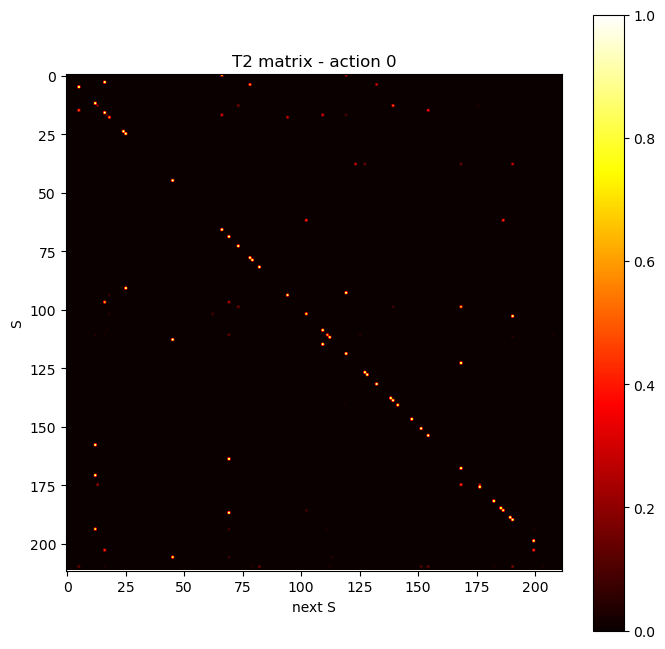

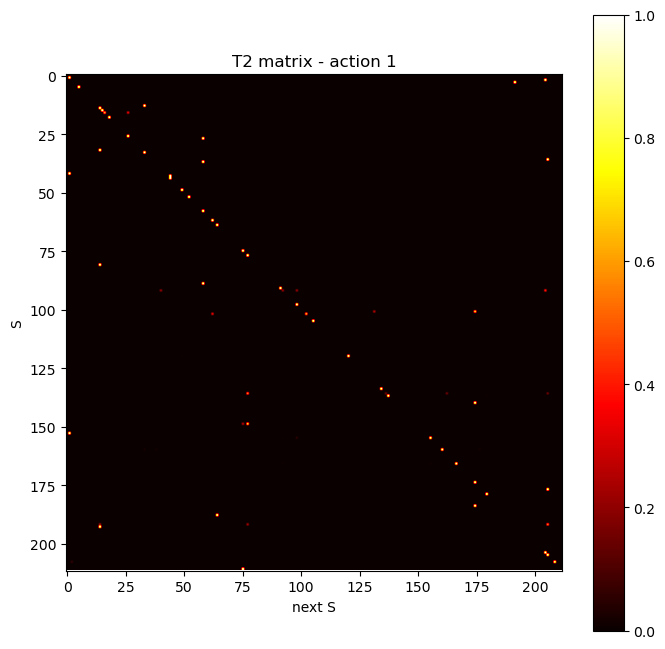

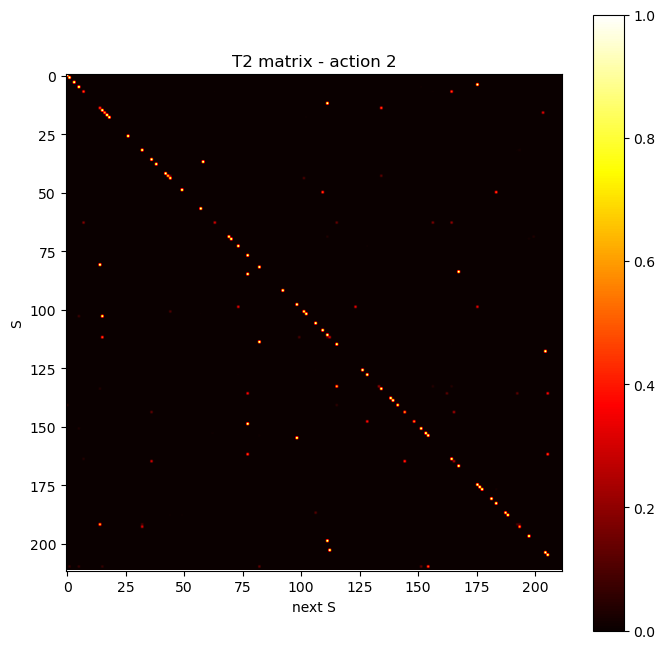

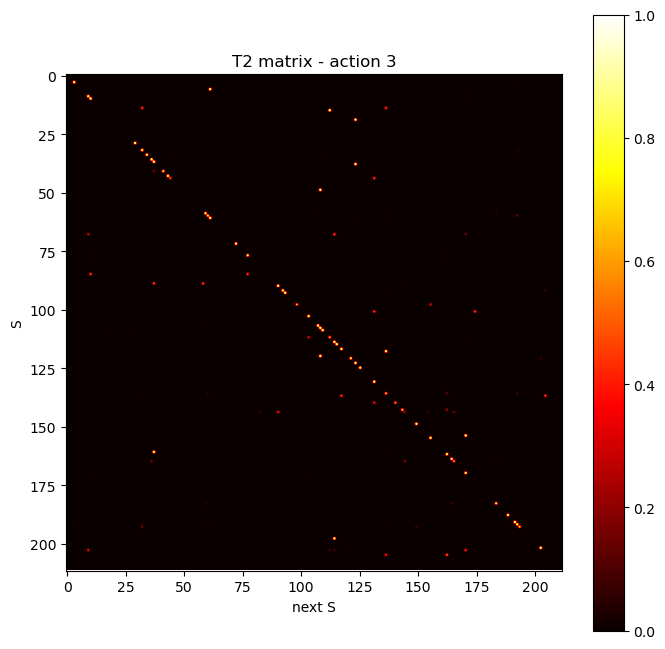

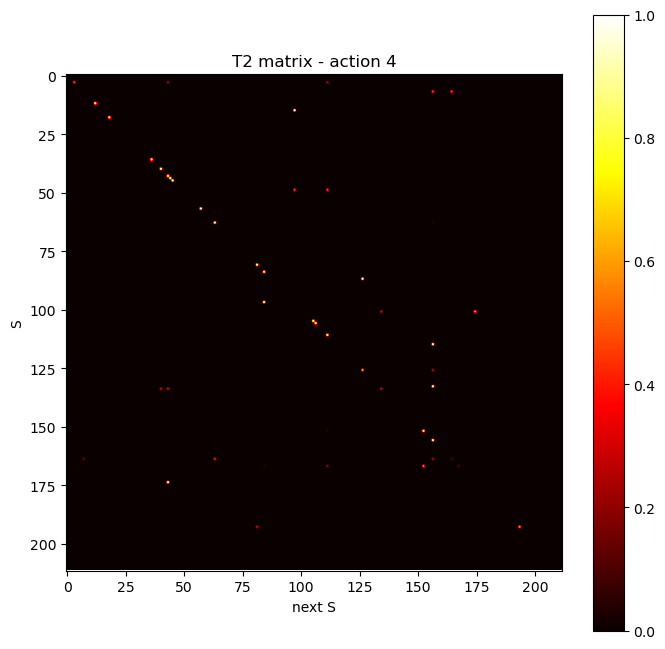

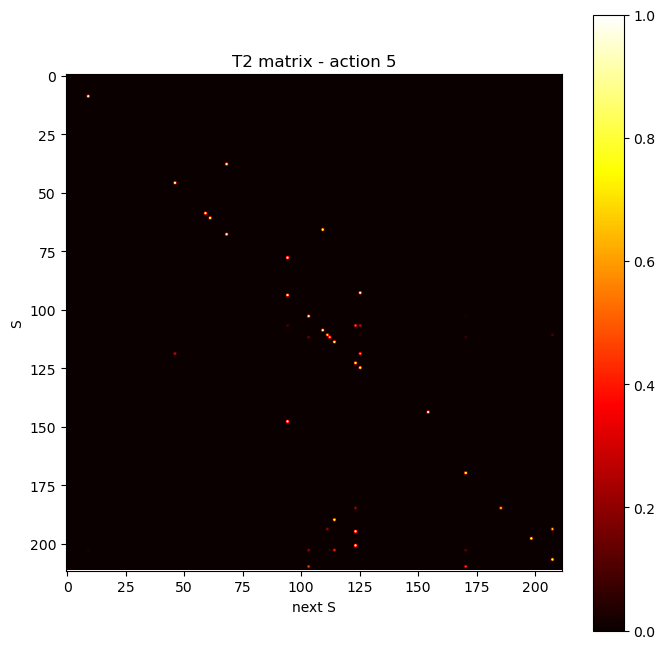

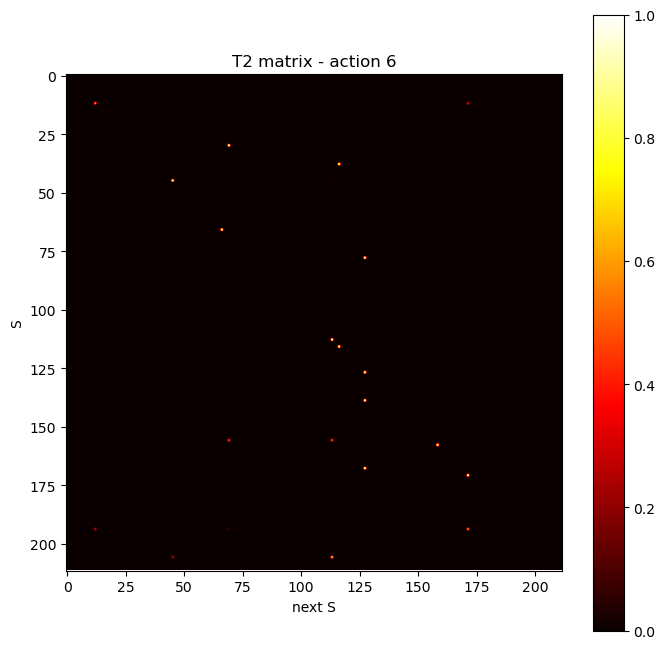

In [6]:
for action in range(df_mdp['At'].max()+1):
    M = T[:, :, action]
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(M, cmap='hot')
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.title('T2 matrix - action ' + str(action))
    ax.set_xlabel('next S')
    ax.set_ylabel('S')
    plt.show()

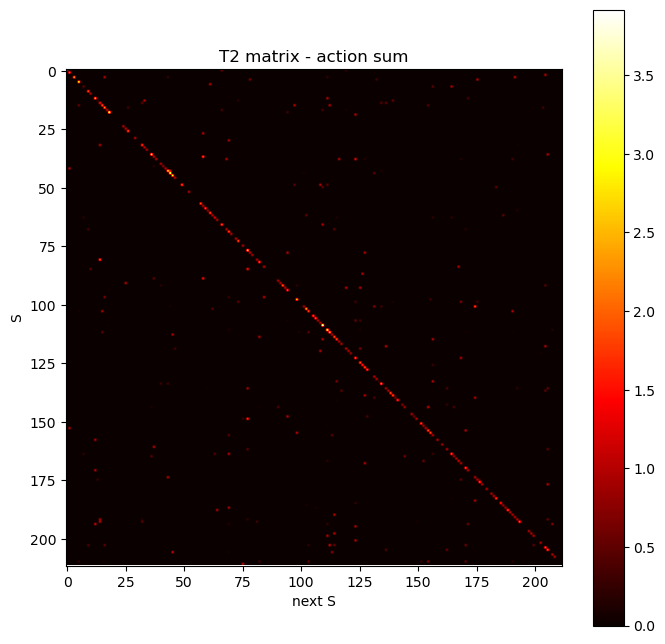

In [7]:
#compute T_cum on axis 2 of T
T_cum = np.sum(T, axis=2)

M = T_cum
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(M, cmap='hot')
#for i in range(len(index)):
#    if index[i][1] == action:
#        ax.scatter(index[i][0], index[i][0], marker='o', color='black', s=0.5)
cbar = ax.figure.colorbar(im, ax=ax)
plt.title('T2 matrix - action sum')
ax.set_xlabel('next S')
ax.set_ylabel('S')
plt.show()


In [14]:
# check if T[s,s_,a] describes a markov decision process
not_null_r = []
null_r = []
for a in range(T.shape[2]):
    for s in range(T.shape[0]):
        if not np.isclose(T[s,:,a].sum(), 1.0, rtol = 1e-3, atol = 1e-3):
            if T[s,:,a].sum() == 0:
                print('elemento non stocastico dato  da riga nulla')
                null_r.append((s,a))
            else:
                print('elemento non stocastico, riga non nulla')
                not_null_r.append((s,a))

elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da riga nulla
elemento non stocastico dato  da

In [32]:

print(nnidx)
print(len(nnidx))
T_custom = T.copy()
for index in nnidx:
    T_custom[index[0],index[0],index[1]] = 1

[(1, 0), (2, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (14, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (63, 0), (64, 0), (65, 0), (67, 0), (68, 0), (70, 0), (71, 0), (72, 0), (74, 0), (75, 0), (76, 0), (77, 0), (80, 0), (81, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (92, 0), (95, 0), (96, 0), (98, 0), (100, 0), (101, 0), (104, 0), (105, 0), (106, 0), (107, 0), (108, 0), (110, 0), (114, 0), (116, 0), (117, 0), (118, 0), (120, 0), (121, 0), (122, 0), (124, 0), (125, 0), (126, 0), (129, 0), (130, 0), (131, 0), (133, 0), (134, 0), (135, 0), (136, 0), (137, 0), (140, 0), (142, 0), (143, 0), (144, 0), (145, 0), (146, 0), (148, 0), (149, 0),

AttributeError: module 'gym.envs' has no attribute 'toy_text'

## Policy & Value Iteration

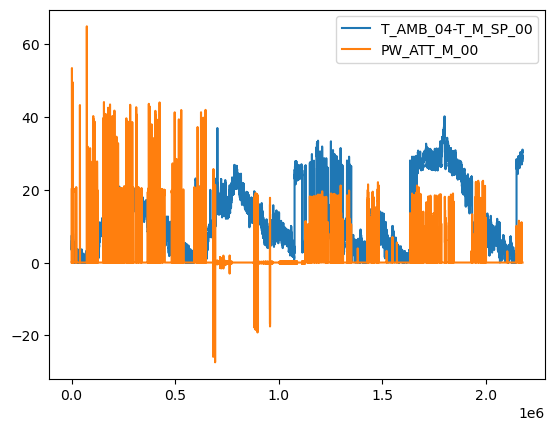

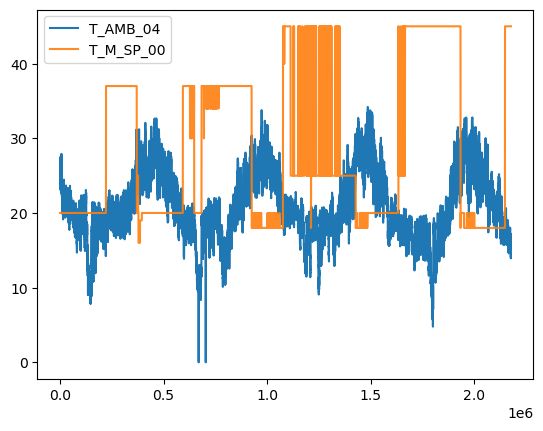

In [86]:
# select from df, df['T_AMB_04','T_M_SP_00','PW_ATT_M_00']
df[['T_AMB_04','T_M_SP_00','PW_ATT_M_00']]
y1 = abs(df['T_AMB_04']-df['T_M_SP_00'])
y2 = df['PW_ATT_M_00']
y3 = df['T_AMB_04']
y4 = df['T_M_SP_00']
x = df.shape[0]
plt.plot(range(x), y1, label='T_AMB_04-T_M_SP_00')
plt.plot(range(x), y2, label='PW_ATT_M_00')
plt.legend()
plt.title('T_AMB_04-T_M_SP_00 and PW_ATT_M_00')
plt.show()

plt.plot(range(x), y3, label='T_AMB_04')
plt.plot(range(x), y4, label='T_M_SP_00', alpha=0.9)
plt.legend()
plt.title('T_AMB_04 and T_M_SP_00')
plt.show()


In [45]:
def build_reward_array(df, df_mdp, n_clusters):

    mean_pw_m = np.zeros(n_clusters)
    mean_delta_t = np.zeros(n_clusters)

    df['T_AMB_mean'] = df[["T_AMB_00", "T_AMB_01", "T_AMB_02", "T_AMB_03"]].mean(axis=1)
   
    for s in range(n_clusters):

        current_cluster = df.loc[df_mdp['S'] == s]
                
        if (current_cluster['PW_ATT_M_00'] == 0).all():
            mean_pw_m[s] = 0
        else:
            mean_pw_m[s] = current_cluster['PW_ATT_M_00'].mean()
        
        if (current_cluster['T_M_SP_00'].mean() - current_cluster['T_AMB_mean']== 0).all():
            mean_delta_t[s] = 0
        else:
            mean_delta_t[s] = current_cluster['T_M_SP_00'].mean() - current_cluster['T_AMB_mean'].mean()   
    print(mean_pw_m, mean_delta_t)
    return mean_pw_m, mean_delta_t

def dp_graphs_pi(policy_1a, value_1a, policy_3a, value_3a, k):

   # Numero di elementi sull'asse x
    num_elements = len(policy_1a)

    # Crea un array di indici degli elementi sull'asse x
    indices = np.arange(num_elements)

    # Crea il primo istogramma per la policy
    plt.bar(indices, policy_1a, align='center', alpha=0.7, color='blue')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Policy')
    title = 'Policy Iteration: policy (1a) - k = '+ str(k)
    plt.title(title)
    plt.show()

    # Crea il secondo istogramma per il value
    plt.bar(indices, value_1a, align='center', alpha=0.7, color='red')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Value')
    title = 'Policy Iteration: value (1a) - k = '+ str(k)
    plt.title(title)
    plt.show() 

    # Numero di elementi sull'asse x
    num_elements = len(policy_3a)

    # Crea un array di indici degli elementi sull'asse x
    indices = np.arange(num_elements)

    # Crea il primo istogramma per la policy
    plt.bar(indices, policy_3a, align='center', alpha=0.7, color='blue')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Policy')
    title = 'Policy Iteration: policy (3a) - k = '+ str(k)
    plt.title(title)
    plt.show()

    # Crea il secondo istogramma per il value
    plt.bar(indices, value_3a, align='center', alpha=0.7, color='red')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Value')
    title = 'Policy Iteration: value (3a) - k = '+ str(k)
    plt.title(title)
    plt.show() 

def dp_graphs_pv(policy, value, k, title):

    # Numero di elementi sull'asse x
    num_elements = len(policy)

    # Crea un array di indici degli elementi sull'asse x
    indices = np.arange(num_elements)

    # Crea il primo istogramma per la policy
    plt.bar(indices, policy, align='center', alpha=0.7, color='blue')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Policy')
    plt.title(title + ': policy  - k = '+ str(k))
    plt.show()

    # Crea il secondo istogramma per il value
    plt.bar(indices, value, align='center', alpha=0.7, color='red')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Value')
    plt.title(title + ': value - k = '+ str(k))
    plt.show()

    
        
def dp_graphs_vi(policy_1a, value_1a, policy_3a, value_3a, k):

    # Numero di elementi sull'asse x
    num_elements = len(policy_1a)

    # Crea un array di indici degli elementi sull'asse x
    indices = np.arange(num_elements)

    # Crea il primo istogramma per la policy
    plt.bar(indices, policy_1a, align='center', alpha=0.7, color='blue')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Policy')
    title = 'Value Iteration: policy (1a) - k = '+ str(k)
    plt.title(title)
    plt.show()

    # Crea il secondo istogramma per il value
    plt.bar(indices, value_1a, align='center', alpha=0.7, color='red')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Value')
    title = 'Value Iteration: value (1a) - k = '+ str(k)
    plt.title(title)
    plt.show()

    # Numero di elementi sull'asse x
    num_elements = len(policy_3a)

    # Crea un array di indici degli elementi sull'asse x
    indices = np.arange(num_elements)

    # Crea il primo istogramma per la policy
    plt.bar(indices, policy_3a, align='center', alpha=0.7, color='blue')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Policy')
    title = 'Value Iteration: policy (3a) - k = '+ str(k)
    plt.title(title)
    plt.show()

    # Crea il secondo istogramma per il value
    plt.bar(indices, value_3a, align='center', alpha=0.7, color='red')
    plt.xticks(indices, indices)
    plt.xlabel('Indice')
    plt.ylabel('Value')
    title = 'Value Iteration: value (3a) - k = '+ str(k)
    plt.title(title)
    plt.show()

def cumulative_reward_progressive(cumulative_reward):
    cum_rew_prog = []
    cum_sum = 0
    for r in range(len(cumulative_reward)):
        cum_sum += cumulative_reward[r]
        cum_rew_prog.append(cum_sum)
    return cum_rew_prog


        




il k significativo è identificato con k = 1-(1-e-25) [norm]

In [49]:
n_clusters = df_mdp['S'].max() + 1
n_actions = df_mdp['At'].max()+1

#scaler_norm = MinMaxScaler()
#df_rew_norm = scaler_norm.fit_transform(df_rew)
#df_rew_norm = pd.DataFrame(df_rew_norm, columns=df_rew.columns)
reward_array = build_reward_array(df=df_rew, df_mdp=df_mdp_norm, n_clusters=n_clusters)

high_k = 1-(1e-25)
K = [0, 1]#high_k]
R_list = []
policy_opt = []
draw = False
draw_reward = False
compute_cumulative_reward = False
#T = T_clean.copy()

print('Number of clusters: ', n_clusters)
print('Number of actions: ', n_actions)

penalty = -100

for k in K:

    R = np.zeros((n_clusters, n_actions))
    for s in range(n_clusters):
        r0 = - k * reward_array[0][s] - (1-k) * reward_array[1][s]
        R[s, :] = r0
    
    for i in index:
        R[i] = penalty

    R_list.append(R)
  
    ####### POLICY ITERATION #######

    v_init = np.zeros(T.shape[0])
    p_init = np.random.randint(T.shape[2], size=T.shape[0])
    policy_1a, value_1a = policy_iteration(T, R=R, gamma=0.99, v_init=v_init, pi_init=p_init, index_list=index,tol=1.0e-4)
    policy_1a = policy_1a.reshape(-1)

    policy_opt.append(policy_1a)

if len(K) == 2:
    if np.array_equal(policy_opt[0], policy_opt[1]):
        print('Policies are the same')
    else:
        print('Policies are different')
        # print how many different elements there are
        print('Number of different elements: ', np.count_nonzero(policy_opt[0] - policy_opt[1]))

x_ax = range(len(df_mdp))
cumulative_reward = []
cr_array = []

if draw_reward == True:

    if len(R_list) != len(policy_opt):
        print('ERROR: different number of rewards and policies')
        print('Number of rewards: ', len(R_list)), print('\nNumber of policies: ', len(policy_opt)) 

    color_list = ['blue', 'red', 'green', 'orange', 'purple']

    if len(color_list) < len(R_list):
        for i in range(len(R_list) - len(color_list)):
            color_list.append('#%06X' % random.randint(0, 0xFFFFFF))

    fig = plt.figure(figsize=(10,6))
    
    for ind in range(len(R_list)):
        start = time.time()
        color = color_list[ind]
        R = R_list[ind]
        kk = K[ind]
        policy = policy_opt[ind]
        # asse delle ordinate
        rewards = []
        for data in range(len(df_mdp)):
            s = df_mdp.iloc[data]['S']
            a = policy[s]
            rewards.append(R[s, a])
        #plt.plot(x_ax, rewards, color=color, label='k = ' + str(kk))
        #print('k = ', kk, ' - completed in ', time.time() - start, ' seconds')
        cumulative_reward.append(sum(rewards))
        CR = cumulative_reward_progressive(rewards)
        cr_array.append(CR)
    #plt.xlabel('Indice')
    #plt.ylabel('Reward')
    #plt.title('Policy Iteration - Rewards')
    #plt.legend()
    #plt.show()

if compute_cumulative_reward == True:
    for c in range(len(cr_array)):
        xx = range(len(cr_array[c]))
        yy = cr_array[c]
        plt.plot(xx, yy, color=color_list[c], label='k = ' + str(K[c]))
    #set font size
    plt.xlabel('Indice')
    plt.ylabel('Cumulative Reward')
    plt.title('Policy Iteration - Cumulative Rewards')
    #put the legend upper right
    plt.legend(loc='upper right')
    plt.show()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.31870479e+00
  0.00000000e+00  2.80466842e-04  0.00000000e+00 -3.17769716e-02
  0.00000000e+00  1.67352596e+00  8.24553350e+00  0.00000000e+00
  1.92165197e+01  1.52164065e+01  9.39391475e-03  8.03937231e-04
  0.00000000e+00  3.46843120e-02  1.20061480e-01  1.63445000e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.37555294e-03  1.96855000e+01  0.00000000e+00
  5.95292341e+00  0.00000000e+00  4.72547170e+00  0.00000000e+00
  5.60237697e+00  7.69728802e+00  2.01263992e-03  0.00000000e+00
  6.78627451e+00  5.80509554e+00  0.00000000e+00  1.15741717e+01
  2.66754788e-01  1.72757076e+01  5.43279054e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.19797857e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.50738607e+01  0.00000000e+00  1.70549003e+00
  7.05063265e+00  9.73337

# Simulazione Modello Markoviano


## Setting best MDP

In [46]:
T, index = build_T(df_mdp)

n_clusters = df_mdp['S'].max() + 1
n_actions = df_mdp['At'].max()+1

reward_array = build_reward_array(df=df_rew, df_mdp=df_mdp_norm, n_clusters=n_clusters)
R = np.zeros((n_clusters, n_actions))

k = 1-(1e-25)

for s in range(n_clusters):
    r0 = - k * reward_array[0][s] - (1-k) * reward_array[1][s]
    R[s, :] = r0

penalty = -100
for i in index:
    R[i] = penalty

v_init = np.zeros(T.shape[0])
p_init = np.random.randint(T.shape[2], size=T.shape[0])
policy_opt, value_opt = policy_iteration(T, R=R, gamma=0.99, v_init=v_init, pi_init=p_init, index_list=index,tol=1.0e-4)
policy_opt = policy_opt.reshape(-1)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.31870479e+00
  0.00000000e+00  2.80466842e-04  0.00000000e+00 -3.17769716e-02
  0.00000000e+00  1.67352596e+00  8.24553350e+00  0.00000000e+00
  1.92165197e+01  1.52164065e+01  9.39391475e-03  8.03937231e-04
  0.00000000e+00  3.46843120e-02  1.20061480e-01  1.63445000e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.37555294e-03  1.96855000e+01  0.00000000e+00
  5.95292341e+00  0.00000000e+00  4.72547170e+00  0.00000000e+00
  5.60237697e+00  7.69728802e+00  2.01263992e-03  0.00000000e+00
  6.78627451e+00  5.80509554e+00  0.00000000e+00  1.15741717e+01
  2.66754788e-01  1.72757076e+01  5.43279054e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.19797857e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.50738607e+01  0.00000000e+00  1.70549003e+00
  7.05063265e+00  9.73337

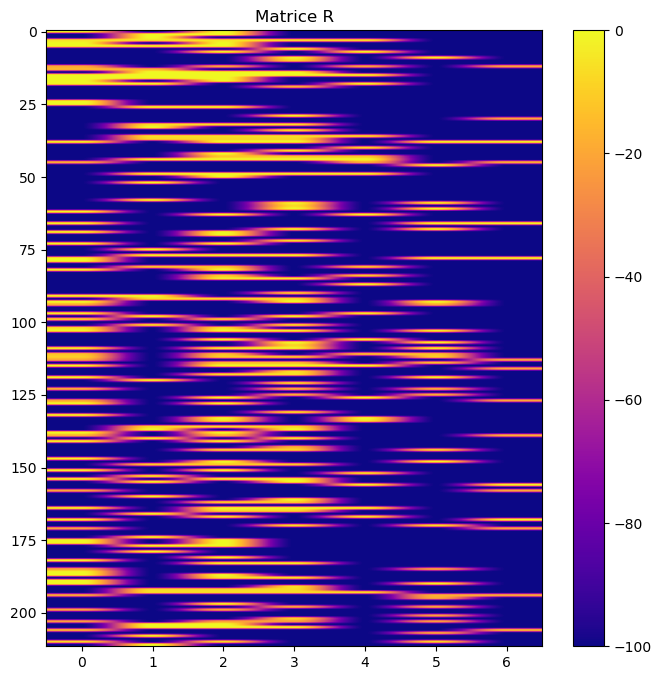

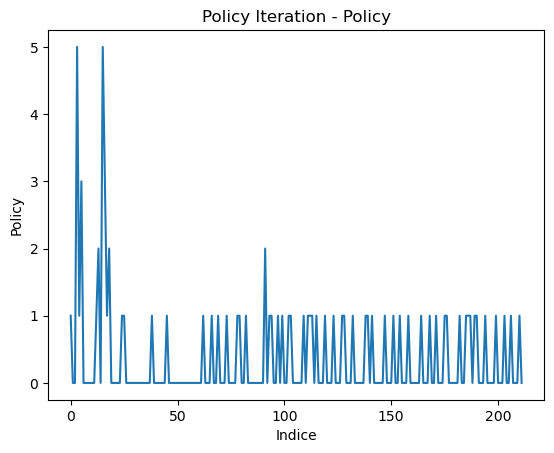

In [47]:
plt.figure(figsize=(8, 8))
plt.imshow(R, cmap='plasma', vmin=-100, vmax=0, aspect='auto')
plt.colorbar()
plt.title('Matrice R')
plt.show()


plt.plot(policy_opt)
plt.xlabel('Indice')
plt.ylabel('Policy')
plt.title('Policy Iteration - Policy')
plt.show()

## Simulation

Initial state:  206


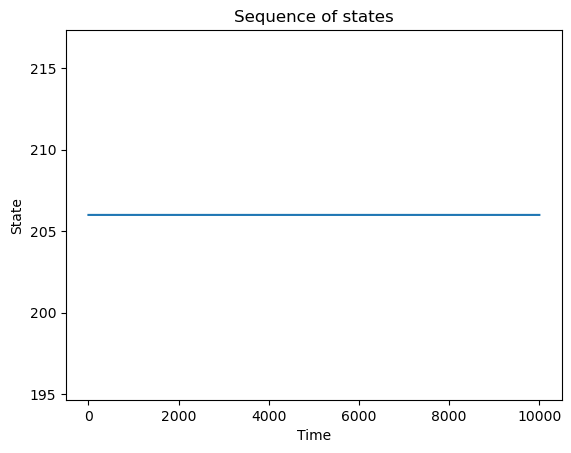

Cumulative reward:  -1000000.0


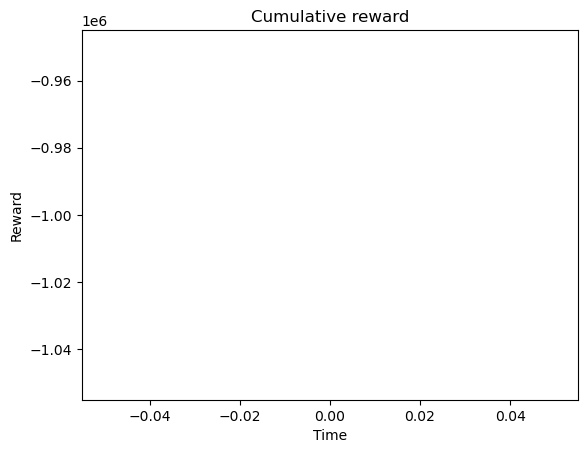

In [ ]:
def simulate_step(T, policy, s0, R):
    a = policy[s0]
    possibilities = T[s0, :, a]
    nonzero_indices = np.nonzero(possibilities)[0]
    if len(nonzero_indices) > 1:
        next_state = np.random.choice(nonzero_indices, p=possibilities[nonzero_indices])
        print('nonzero_indices: ', nonzero_indices)
    else:
        next_state = np.random.choice(nonzero_indices)
    reward = R[s0, a]
    return next_state, reward


# Simulate the sequence of states and rewards and compute the cumulative reward
def simulate_episode(T, policy, s0, R, steps):
    s = s0
    cumulative_reward = 0
    states = []
    rewards = []
    states.append(s)
    while steps > 0:
        s_, r = simulate_step(T, policy, s, R)
        states.append(s)
        rewards.append(r)
        cumulative_reward += r
        s = s_
        steps -= 1
    return states, rewards, cumulative_reward

s0 = np.random.randint(T.shape[0])
policy_ran = np.random.randint(T.shape[2], size=T.shape[0])
steps = 1e4

print('Initial state: ', s0)

states, rewards, cumulative_reward = simulate_episode(T, policy=policy_ran, s0=s0, R=R, steps=steps)


# plot the sequence of states and rewards
plt.plot(states)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Sequence of states')
plt.show()

print('Cumulative reward: ', cumulative_reward)
plt.plot(cumulative_reward)
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Cumulative reward')
plt.show()




In [ ]:
for a in range(7):
    #find rows != 0 for action a and state s0=12
    print('Action: ', a)
    print('Rows: ', np.argwhere(T[12, :, a] != 0))




Action:  0
Rows:  [[ 0]
 [12]]
Action:  1
Rows:  [[12]]
Action:  2
Rows:  [[ 2]
 [12]]
Action:  3
Rows:  [[12]]
Action:  4
Rows:  [[ 4]
 [12]]
Action:  5
Rows:  [[12]]
Action:  6
Rows:  [[ 6]
 [12]]


In [ ]:
# simulate the transition from s0 = 12 into the next state
s0 = 12
a = 0
possibilities = T[s0, :, a]
nonzero_indices = np.nonzero(possibilities)[0]
print('Nonzero indices: ', nonzero_indices)
#take a random choice from the nonzero indices
next_state = np.random.choice(nonzero_indices, p=possibilities[nonzero_indices])
print('Next state: ', next_state)

# for 1000 steps count how many times each state is visited
s0 = 12
a = 0
steps = 1000
visited_states = np.zeros(T.shape[0])
for i in range(steps):
    possibilities = T[s0, :, a]
    nonzero_indices = np.nonzero(possibilities)[0]
    next_state = np.random.choice(nonzero_indices, p=possibilities[nonzero_indices])
    visited_states[next_state] += 1
print('Visited states: ', visited_states)



Nonzero indices:  [ 0 12]
Next state:  12


Visited states:  [508.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 492.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.